In [1]:
# import libraries
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Set seed for reproducibility
tf.random.set_seed(42)

In [3]:
# Load MNIST dataset (60,000 images of 28x28 digits)
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 15s 1us/step


In [4]:
# Normalize to [-1, 1] range and reshape
train_images = (train_images - 127.5) / 127.5
train_images = np.expand_dims(train_images, axis=-1)

In [5]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Prepare data pipeline
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((7, 7, 256)),  # Reshape to 7x7 image

        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

generator = build_generator()


e:\Python & AI Bootcamp\.bootcampai\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

discriminator = build_discriminator()


e:\Python & AI Bootcamp\.bootcampai\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Losses and Optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)  # Real = 1
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)  # Fake = 0
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)  # Fool the discriminator

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
# Training Loops
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# Seed for consistent image generation
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
import os
from IPython.display import clear_output
# Generate and Save Images
def generate_and_plot_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')  # Rescale from [-1,1] to [0,255]
        plt.axis('off')
    plt.suptitle(f"Epoch {epoch}")
    plt.tight_layout()
    plt.show()

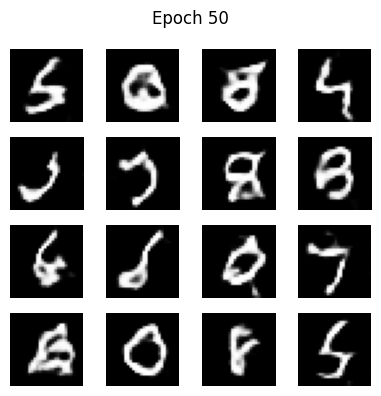

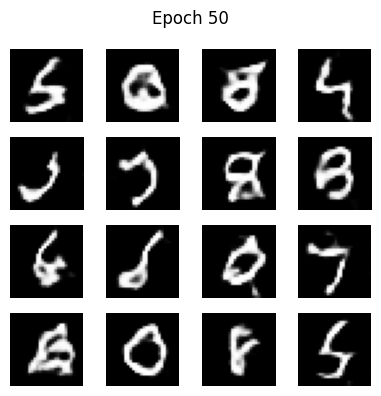

In [11]:
# train the gan
def train(dataset, epochs):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        for image_batch in dataset:
            train_step(image_batch)

        clear_output(wait=True)
        generate_and_plot_images(generator, epoch + 1, seed)

    # Final image
    generate_and_plot_images(generator, epochs, seed)

train(train_dataset, EPOCHS)